## Import neccessary model

In [1]:
# !pip install torchinfo
import os
import pandas as pd
import numpy as np
import cv2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader, ConcatDataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import ToTensor
from PIL import Image
import os
# from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision import transforms
from torchinfo import summary
import timm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Preprocessing Dataset: Conver mask to BRG, Override get_item,..

In [2]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = [f for f in os.listdir(self.img_dir) if os.path.isfile(os.path.join(self.img_dir, f))]

    def __len__(self):
        return len(self.images)

    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        red_mask = self.create_color_mask(image, (0, 100, 20), (10, 255, 255)) + \
                   self.create_color_mask(image, (160, 100, 20), (179, 255, 255))

        green_mask = self.create_color_mask(image, (36, 25, 25), (70, 255, 255))

        full_mask = np.bitwise_or(red_mask, green_mask).astype(np.uint8)
        full_mask = np.expand_dims(full_mask, axis=-1)

        return full_mask

    def create_color_mask(self, image, lower, upper):
        color_mask = cv2.inRange(image, np.array(lower), np.array(upper))
        color_mask[color_mask != 0] = 1
        return color_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        label = self.read_mask(label_path)
        image = cv2.resize(image, self.resize)

        # Apply the same augmentation to both image and label
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']

        label = label.permute(2, 0, 1).to(torch.float32)

        return image, label




In [3]:
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))
    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)    

## Load dataset

In [4]:
image_path = []
TRAIN_DIR = '/kaggle/input/bkai-igh-neopolyp/train/train'
for root, dirs, files in os.walk(TRAIN_DIR):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)
len(image_path)

1000

In [5]:
mask_path = []
TRAIN_MASK_DIR = '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt'
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    #iterate over 1000 masks
    for file in files:
        # obtain the path"
        path = os.path.join(root,file)
        # add path to the list
        mask_path.append(path)
len(mask_path)

1000

## Data Augmentation: Mix with original data, Normalize, Set batch size

In [6]:
import cv2
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.transforms import ToTensor
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Adjusted batch size
batch_size = 4

# Adjusted values for augmentation
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.OneOf([A.Blur(), A.GaussianBlur(), A.GlassBlur(), A.MotionBlur(), A.GaussNoise(), A.Sharpen(), A.MedianBlur(), A.MultiplicativeNoise()]),
    A.CoarseDropout(p=0.2, max_height=35, max_width=35, fill_value=255),
    A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.15, brightness_coeff=1.5, p=0.09),
    A.RandomShadow(p=0.1),
    A.ShiftScaleRotate(p=0.45, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.15, scale_limit=0.15),
    A.RandomCrop(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.475, 0.450, 0.415), std=(0.239, 0.234, 0.225)),
    ToTensorV2(),
])
new_train_transform = A.Compose([
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.6),
    A.RandomGamma(gamma_limit=(60, 100), eps=None, always_apply=False, p=0.4),
    A.RGBShift(p=0.4, r_shift_limit=9, g_shift_limit=3, b_shift_limit=5),
    A.OneOf([A.Blur(), A.GaussianBlur(), A.GlassBlur(), A.MotionBlur(), A.GaussNoise(), A.Sharpen(), A.MedianBlur(), A.MultiplicativeNoise()]),
    A.CoarseDropout(p=0.3, max_height=40, max_width=40, fill_value=255),
    A.RandomSnow(snow_point_lower=0.08, snow_point_upper=0.13, brightness_coeff=1.7, p=0.1),
    A.RandomShadow(p=0.15),
    A.ShiftScaleRotate(p=0.5, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.2, scale_limit=0.2),
    A.RandomCrop(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_dataset_not_aug = CustomDataset(img_dir=TRAIN_DIR,
                                          label_dir=TRAIN_MASK_DIR,
                                          resize=(256, 256),
                                          transform=val_transform)

new_train_dataset_aug = CustomDataset(img_dir=TRAIN_DIR,
                                          label_dir=TRAIN_MASK_DIR,
                                          resize=(256, 256),
                                          transform=new_train_transform)

train_dataset_aug = CustomDataset(img_dir=TRAIN_DIR,
                                      label_dir=TRAIN_MASK_DIR,
                                      resize=(256, 256),
                                      transform=train_transform)
# train_dataset_not_aug, , 
train_dataset = ConcatDataset([new_train_dataset_aug, train_dataset_aug])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataset))


2000


Image:  torch.Size([3, 256, 256]) Label:  torch.Size([1, 256, 256])


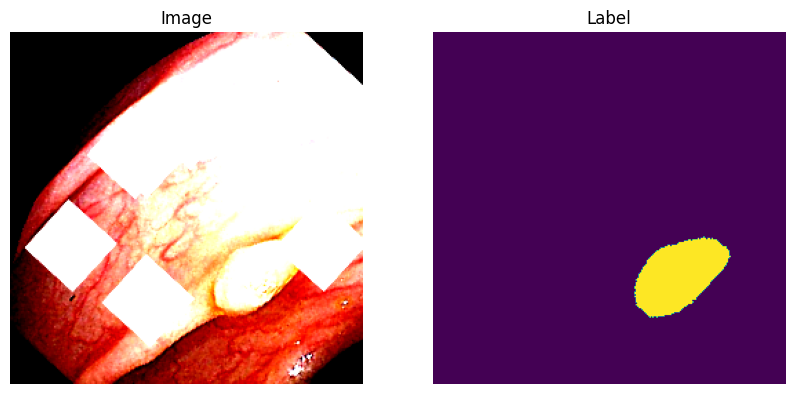

In [7]:
image,label = train_dataset[300]
print('Image: ', image.shape, 'Label: ', label.shape)

label_array = label.permute(1, 2, 0).numpy()
image_array = image.permute(1, 2, 0).numpy()
# Create a figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_array)
axs[0].set_title('Image')
axs[0].axis('off')  

axs[1].imshow(label_array)
axs[1].set_title('Label')
axs[1].axis('off')  

plt.show()

## Encoder Block

In [8]:
class encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        next_layer = self.max_pool(x)
        skip_layer = x
        
        return next_layer, skip_layer

## Decoder Block

In [9]:
class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(decoder_block, self).__init__()
        
        self.transpose_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x, skip_layer):
        x = self.transpose_conv(x)
        x = torch.cat([x, skip_layer], axis=1)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

## Bottleneck Block

In [10]:
class bottleneck_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(bottleneck_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

## Full Unet

In [11]:
# UNet model
class UNet(nn.Module):
    def __init__(self, n_class=3):
        super(UNet, self).__init__()
        # Encoder blocks
        self.enc1 = encoder_block(3, 64)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = encoder_block(128, 256)
        self.enc4 = encoder_block(256, 512)
        
        # Bottleneck block
        self.bottleneck = bottleneck_block(512, 1024)
        
        # Decoder blocks
        self.dec1 = decoder_block(1024, 512)
        self.dec2 = decoder_block(512, 256)
        self.dec3 = decoder_block(256, 128)
        self.dec4 = decoder_block(128, 64)
        
        # 1x1 convolution
        self.out = nn.Conv2d(64, n_class, kernel_size=1, padding='same')
        
    def forward(self, image):
        n1, s1 = self.enc1(image)
        n2, s2 = self.enc2(n1)
        n3, s3 = self.enc3(n2)
        n4, s4 = self.enc4(n3)
        
        n5 = self.bottleneck(n4)
        
        n6 = self.dec1(n5, s4)
        n7 = self.dec2(n6, s3)
        n8 = self.dec3(n7, s2)
        n9 = self.dec4(n8, s1)
        
        output = self.out(n9)
        
        return output

### Init Model Unet

In [12]:
torch.cuda.empty_cache()
model = UNet(3)

### Setup hyperparameter for optimizer: Adam Optimizer

In [13]:
# Define the optimizer (e.g., Adam optimizer)
# learning_rate = 0.01
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### Load before continue training

In [14]:
checkpoint = torch.load('/kaggle/input/trained-model-4/colorization_model (4).pth')
model.load_state_dict(checkpoint['model'])
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Thay đổi các tham số theo cấu hình của bạn
# Nạp trạng thái của optimizer từ checkpoint
optimizer.load_state_dict(checkpoint['optimizer'])

optimizer.param_groups[0]['lr'] = 0.00001
weight_decay = 0.005  # Adjust as needed
for param_group in optimizer.param_groups:
    param_group['weight_decay'] = weight_decay
# Sau khi nạp trạng thái, đưa cả model và optimizer lên device
model.to(device)
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)
loss_value = checkpoint['loss']
# print('Old optimizer: ',checkpoint['optimizer'])

print(f"The loss from the checkpoint is: {loss_value:.10f}")

The loss from the checkpoint is: 0.0317656238


## Setup Wandb

In [15]:
import wandb
# wandb.login()

In [16]:

!wandb login '39dfa65a7ff4076b9db7aaeed60ce25894d086b6'

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [17]:
# wandb login --relogin

39dfa65a7ff4076b9db7aaeed60ce25894d086b6

In [18]:

wandb.init(
    # set the wandb project where this run will be logged
    project="Polyp-DL",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": checkpoint['learning_rate'],
    "architecture": "UNet",
    "dataset": "Polyp",
    "epochs": 250,
    }
)

wandb: Currently logged in as: thiemdrem2003 (thiemcun). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.12
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231113_210412-iaqvk81d
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run twilight-planet-21
wandb: ⭐️ View project at https://wandb.ai/thiemcun/Polyp-DL
wandb: 🚀 View run at https://wandb.ai/thiemcun/Polyp-DL/runs/iaqvk81d


## Training Model

In [19]:
from torch.utils.data import Subset
new_train_transform = A.Compose([
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.6),
    A.RandomGamma(gamma_limit=(60, 100), eps=None, always_apply=False, p=0.4),
    A.RGBShift(p=0.4, r_shift_limit=9, g_shift_limit=3, b_shift_limit=5),
    A.OneOf([A.Blur(), A.GaussianBlur(), A.GlassBlur(), A.MotionBlur(), A.GaussNoise(), A.Sharpen(), A.MedianBlur(), A.MultiplicativeNoise()]),
    A.CoarseDropout(p=0.3, max_height=40, max_width=40, fill_value=255),
    A.RandomSnow(snow_point_lower=0.08, snow_point_upper=0.13, brightness_coeff=1.7, p=0.1),
    A.RandomShadow(p=0.15),
    A.ShiftScaleRotate(p=0.5, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.2, scale_limit=0.2),
    A.RandomCrop(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_batch_size = 4
subset_size = 100
subset_indices = list(range(subset_size))

# Create datasets for validation
val_dataset = CustomDataset(img_dir=TRAIN_DIR,  # Assuming you have a separate directory for validation data
                            label_dir=TRAIN_MASK_DIR,
                            resize=(256, 256),
                            transform=new_train_transform)


val_dataset = Subset(val_dataset, subset_indices)

# Create validation data loader
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

In [20]:
# Set the number of training epochs
num_epochs = 250
# 

# Define the learning rate scheduler
# scheduler = StepLR(optimizer, step_size= 5, gamma=0.85)
# Move the model to the device (e.g., GPU)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
train_loss_array = []
# best_loss = checkpoint['loss']
best_loss = 999
# Training loop

early_stopping_threshold = 10  # Stop if validation loss doesn't improve for this many epochs
early_stopping_counter = 0
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train() # turn train mode
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        labels = labels.squeeze(dim=1).long()

        outputs = model(images)

        loss = criterion(outputs, labels)
        
        l2_regularization = torch.tensor(0., device=device)
        for param in model.parameters():
            l2_regularization += torch.norm(param, 2)
        loss += weight_decay * l2_regularization
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() # reset for new gradient 
        total_loss += loss.item()  # Accumulate the loss
        wandb.log({'Loss_batch': loss.item()
              })
    # Update the learning rate
#     scheduler.step()

    # Calculate average loss for the epoch
    epoch_loss = total_loss / len(train_loader)
    train_loss_array.append(epoch_loss)
    wandb.log({'loss': epoch_loss, 'Learning Rate': optimizer.param_groups[0]['lr']
              })
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': epoch_loss,
            'learning_rate': optimizer.param_groups[0]['lr']
        }
        save_path = f'colorization_model.pth'
        torch.save(checkpoint, save_path)
        print('Save model')
    model.eval()
    with torch.no_grad():
        # Compute validation loss
        val_loss = 0
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_labels = val_labels.squeeze(dim=1).long()
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()

        average_val_loss = val_loss / len(val_loader)

        # Early stopping check
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # If validation loss doesn't improve for a certain number of epochs, stop training
        if early_stopping_counter >= early_stopping_threshold:
            checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': epoch_loss,
            'learning_rate': optimizer.param_groups[0]['lr']
            }
            save_path = f'colorization_model.pth'
            torch.save(checkpoint, save_path)
            print('Save model')
            print(f"Early stopping after {epoch+1} epochs. Best Validation Loss: {best_val_loss:.10f}")
            break


Epoch [1/250], Loss: 14.3420897408
Save model
Epoch [2/250], Loss: 13.7074033699
Save model
Epoch [3/250], Loss: 13.2651292477
Save model
Epoch [4/250], Loss: 12.8840891628
Save model
Epoch [5/250], Loss: 12.5329069405
Save model
Epoch [6/250], Loss: 12.2005348873
Save model
Epoch [7/250], Loss: 11.8804589806
Save model
Epoch [8/250], Loss: 11.5753744678
Save model
Epoch [9/250], Loss: 11.2762245464
Save model
Epoch [10/250], Loss: 10.9883090038
Save model
Epoch [11/250], Loss: 10.7039027195
Save model
Epoch [12/250], Loss: 10.4275875587
Save model
Save model
Early stopping after 12 epochs. Best Validation Loss: 0.0535373192


## Load Model from Checkpoint

In [21]:
# checkpoint = torch.load('/kaggle/working/colorization_model.pth')
# model.load_state_dict(checkpoint['model'])
# device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Thay đổi các tham số theo cấu hình của bạn

# # Nạp trạng thái của optimizer từ checkpoint
# optimizer.load_state_dict(checkpoint['optimizer'])

# # Sau khi nạp trạng thái, đưa cả model và optimizer lên device
# model.to(device)
# for state in optimizer.state.values():
#     for k, v in state.items():
#         if isinstance(v, torch.Tensor):
#             state[k] = v.to(device)
# loss_value = checkpoint['loss']

# # Move the loss tensor to the appropriate device
# # loss_tensor = loss_tensor.to(device)

# # If you need to use the loss as a Python scalar, for example for printing or comparisons:
# # loss_value = loss_tensor.item()

# # Now you can print or compare `loss_value` as needed
# print(f"The loss from the checkpoint is: {loss_value:.10f}")

### Save Ouput

In [22]:
!mkdir predict_mask
# !mkdir test_overlapmask

In [23]:
trainsize = 256 
model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (trainsize, trainsize))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    new_rgb_mask = np.zeros((*mask.shape, 3)).astype(np.uint8)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb_true = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("predict_mask/{}".format(i), mask_rgb)
    print("processed ", img_path)
     

processed  /kaggle/input/bkai-igh-neopolyp/test/test/f62f215f0da4ad3a7ab8df9da7386835.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/aeeb2b535797395305af926a6f23c5d6.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/2ed9fbb63b28163a745959c03983064a.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/3c84417fda8019410b1fcf0625f608b4.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/8fa8625605da2023387fd56c04414eaa.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/cb1b387133b51209db6dcdda5cc8a788.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/a3657e4314fe384eb2ba3adfda6c1899.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/c695325ded465efde988dfb96d081533.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/0fca6a4248a41e8db8b4ed633b456aaa.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/6f4d4987ea3b4bae5672a230194c5a08.jpeg
processed  /kaggle/input/bkai-igh-neopolyp/test/test/68d4b4ef4d95ceea11957998906d3694.jpeg

In [24]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/predict_mask' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)

/kaggle/working/predict_mask/c7e610b1531871f2fd85a04faeeb2b53.jpeg
/kaggle/working/predict_mask/a6d9ba9d45c3dbc695325ded465efde9.jpeg
/kaggle/working/predict_mask/aafac813fe3ccba3e032dd2948a80c64.jpeg
/kaggle/working/predict_mask/dc0bb223c4eaf3372eae567c94ea04c6.jpeg
/kaggle/working/predict_mask/2d9e593b6be1ac29adbe86f03d900fd1.jpeg
/kaggle/working/predict_mask/02fa602bb3c7abacdbd7e6afd56ea7bc.jpeg
/kaggle/working/predict_mask/780fd497e1c0e9082ea2c193ac8d551c.jpeg
/kaggle/working/predict_mask/e5e8f14e1e0ae936de314f2d95e6c487.jpeg
/kaggle/working/predict_mask/7fda8019410b1fcf0625f608b4ce9762.jpeg
/kaggle/working/predict_mask/cbb2a365b5574868eb60861ee1ff0b8a.jpeg
/kaggle/working/predict_mask/c695325ded465efde988dfb96d081533.jpeg
/kaggle/working/predict_mask/4e2a6e51d077bad31c8c5f54ffaa27a6.jpeg
/kaggle/working/predict_mask/d5060a633a8d5b2b2b55157b7781e2c7.jpeg
/kaggle/working/predict_mask/ff55177a34fc01019eec999fd84e679b.jpeg
/kaggle/working/predict_mask/285e26c90e1797c77826f9a7021bab9f.